In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("/dybfs/users/xuhangkun/SimTAO/offline")
from config import detector_info
import ROOT

Welcome to JupyROOT 6.22/06


In [2]:
def resolution(data,energy_list=range(9),add_edep=1.022):
    cor_res = []
    uncor_res = []
    cor_evis = []
    uncor_evis = []
    for e in energy_list:
        tmp_data = data[data["edep"] > (e + add_edep)*0.9998]
        tmp_data = tmp_data[data["edep"] < (e + add_edep)*1.0002]
        tmp_data = tmp_data.reset_index(drop=True)
        true_hit = tmp_data["true_hit"].to_numpy()
        cor_hit = tmp_data["cor_hit"].to_numpy()
        true_hist = ROOT.TH1F("true_hist","true_hist",100,min(true_hit)-10,max(true_hit)+10)
        cor_hist = ROOT.TH1F("cor_hist","cor_hist",100,min(cor_hit)-10,max(cor_hit)+10)
        for true,cor in zip(true_hit,cor_hit):
            true_hist.Fill(true)
            cor_hist.Fill(cor)
        true_hist.Fit("gaus")
        true_mean = true_hist.GetFunction("gaus").GetParameter(1)
        true_std = true_hist.GetFunction("gaus").GetParameter(2)
        cor_hist.Fit("gaus")
        cor_mean = cor_hist.GetFunction("gaus").GetParameter(1)
        cor_std = cor_hist.GetFunction("gaus").GetParameter(2)
        cor_res.append(cor_std/cor_mean)
        uncor_res.append(true_std/true_mean)
        cor_evis.append(cor_mean/detector_info["energy_scale"])
        uncor_evis.append(true_mean/detector_info["energy_scale"])
        del true_hist
        del cor_hist
    return np.array(cor_evis),np.array(uncor_evis),np.array(cor_res),np.array(uncor_res)

## Reconstruction by ref map

In [6]:
center_positron_ref = pd.read_csv("../data/reconstruction/center_positron_reconstruction_by_ref_map.csv")
center_cor_evis,center_uncor_evis,center_cor,center_uncor = resolution(center_positron_ref)
# read 6year laer data at center
center_positron_6year = []
for i in range(9):
    center_positron_6year.append(
        pd.read_csv("../data/reconstruction/center_positron_%dMeV_reconstruction_by_gamma_map_6years.csv"%(i))
    )
center_positron_6year = pd.concat(center_positron_6year).reset_index(drop=True)
center_cor_evis_6years,center_uncor_evis_6years,center_cor_6years,center_uncor_6years = resolution(center_positron_6year)
# read 6year laer data uniformly
uni_positron_6year = []
for i in range(9):
    uni_positron_6year.append(
        pd.read_csv("../data/reconstruction/uni_positron_%dMeV_reconstruction_by_gamma_map_6years.csv"%(i))
    )
uni_positron_6year = pd.concat(uni_positron_6year).reset_index(drop=True)
uni_cor_evis_6years,uni_uncor_evis_6years,uni_cor_6years,uni_uncor_6years = resolution(uni_positron_6year)
# read 6year laer data uniformly with vertex smear
uni_positron_6year_vs = []
for i in range(9):
    uni_positron_6year_vs.append(
        pd.read_csv("../data/reconstruction/uni_positron_%dMeV_reconstruction_by_gamma_map_6years_vertex_smear.csv"%(i))
    )
uni_positron_6year_vs = pd.concat(uni_positron_6year_vs).reset_index(drop=True)
uni_cor_evis_6years_vs,uni_uncor_evis_6years_vs,uni_cor_6years_vs,uni_uncor_6years_vs = resolution(uni_positron_6year_vs)

5
   3  Sigma        2.90638e+02   1.14964e+00   1.11115e-05   2.83263e-01
 FCN=500.317 FROM MIGRAD    STATUS=CONVERGED      57 CALLS          58 TOTAL
                     EDM=4.82199e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.29885e+03   8.58735e+00   7.61036e-02   1.15445e-04
   2  Mean         3.89772e+04   1.78603e+00   1.85858e-02   8.85323e-05
   3  Sigma        3.16646e+02   1.22729e+00   1.08460e-05   9.27048e-01
 FCN=539.652 FROM MIGRAD    STATUS=CONVERGED      58 CALLS          59 TOTAL
                     EDM=3.5558e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.21528e+03   8.02319e+00   7.39896e-02   1.17236e-04
   2  Mean         3.89739e+04  

## Reconstruction by gamma map

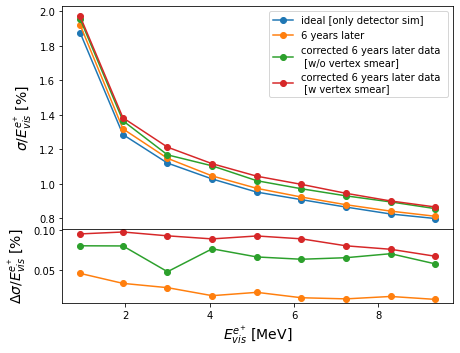

In [12]:
from matplotlib import gridspec
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',   # 使用颜色编码定义颜色
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.figure(figsize=(7,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
gs0 = gridspec.GridSpecFromSubplotSpec(2, 1, height_ratios=[3, 1],subplot_spec=gs[0],hspace=0)
plt.subplot(gs0[0])
plt.plot(center_uncor_evis,100*center_uncor,"o-",label="ideal [only detector sim]",color=colors[0])
plt.plot(center_uncor_evis,100*center_uncor_6years,"o-",label="6 years later",color=colors[1])
plt.plot(center_uncor_evis,100*uni_cor_6years,"o-",label="corrected 6 years later data \n [w/o vertex smear]",color=colors[2])
plt.plot(center_uncor_evis,100*uni_cor_6years_vs,"o-",label="corrected 6 years later data \n [w vertex smear]",color=colors[3])
plt.legend()
plt.ylabel("$\sigma/E_{vis}^{e^{+}}$ [%]",fontsize=14)
plt.subplot(gs0[1])
plt.plot(center_uncor_evis,100*(center_uncor_6years-center_uncor),"o-",color=colors[1])
plt.plot(center_uncor_evis,100*(uni_cor_6years-center_uncor),"o-",color=colors[2])
plt.plot(center_uncor_evis,100*(uni_cor_6years_vs-center_uncor),"o-",color=colors[3])
plt.xlabel("$E_{vis}^{e^{+}}$ [MeV]",fontsize=14)
plt.ylabel("$\Delta\sigma/E_{vis}^{e^{+}}$ [%]",fontsize=14)
# plt.ylim(-0.01,0.1)
plt.show()

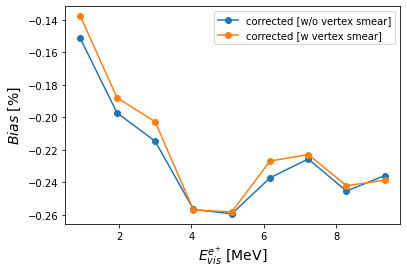

In [13]:
plt.plot(center_uncor_evis,100*(uni_cor_evis_6years - center_uncor_evis_6years)/center_uncor_evis,"o-",label="corrected [w/o vertex smear]")
plt.plot(center_uncor_evis,100*(uni_cor_evis_6years_vs - center_uncor_evis_6years)/center_uncor_evis,"o-",label="corrected [w vertex smear]")
plt.legend()
plt.xlabel("$E_{vis}^{e^{+}}$ [MeV]",fontsize=14)
plt.ylabel("$Bias$ [%]",fontsize=14)
plt.show()